In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,  # 10% of the data will be used for validation
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  # New
    zoom_range=0.2,   # New
    brightness_range=[0.2, 0.9],  # New
    horizontal_flip=True,
    fill_mode='nearest'# it's IMPORTANT
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_data",
    shuffle = True,

    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    # Use the training subset
)

validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_data",
    shuffle = False,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)


Found 7494 images belonging to 10 classes.
Found 2496 images belonging to 10 classes.


In [6]:
model = keras.applications.ResNet152V2(input_shape=(224,224,3),classes=10, weights="imagenet", include_top=False, pooling='avg')
for layer in model.layers:
    layer.trainable = False
flatten = keras.layers.Flatten()(model.output)
xx=keras.layers.Dense(units=704, activation='relu',kernel_regularizer=l2(1e-3))(flatten)
x = keras.layers.Dense(units=10, activation='softmax',kernel_regularizer=l2(1e-3))(xx)
model_resnet = keras.models.Model(model.input, x)
model_resnet.summary()

234545216/234545216 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                           

In [7]:
model = keras.applications.ResNet152V2(input_shape=(224,224,3),classes=10, weights="imagenet", include_top=False, pooling='avg')
for layer in model.layers:
    layer.trainable = False
flatten = keras.layers.Flatten()(model.output)
xx=keras.layers.Dense(units=704, activation='relu',kernel_regularizer=l2(1e-3))(flatten)
x = keras.layers.Dense(units=10, activation='softmax',kernel_regularizer=l2(1e-3))(xx)
model_resnet = keras.models.Model(model.input, x)
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.5281 to fit



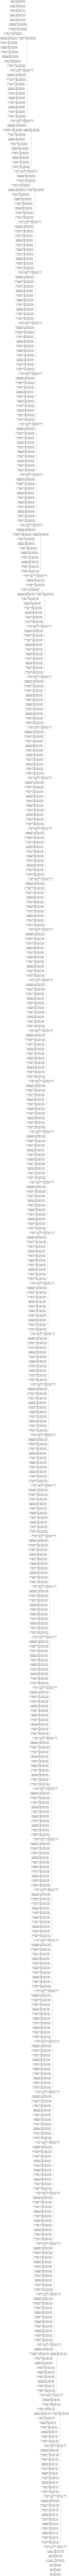

In [15]:
keras.utils.plot_model(model_resnet, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
model_resnet.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1e-3),
              metrics='accuracy')

In [9]:
check= ModelCheckpoint('/content/152v2')
#er_stop=EarlyStopping(min_delta=0.0001,monitor="val_loss",restore_best_weights=True)
lr_pl=ReduceLROnPlateau(monitor="val_accuracy",patience=3,min_delta=0.01,factor=0.05)
train_resnet = model_resnet.fit(train_generator,validation_data=validation_generator,epochs=16,callbacks=[lr_pl,check])

Epoch 1/16
469/469 [==============================] - 2299s 5s/step - loss: 2.5415 - accuracy: 0.4485 - val_loss: 2.1187 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 2/16
469/469 [==============================] - 257s 547ms/step - loss: 1.8540 - accuracy: 0.5562 - val_loss: 1.9666 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 3/16
469/469 [==============================] - 265s 566ms/step - loss: 1.6311 - accuracy: 0.5947 - val_loss: 1.8292 - val_accuracy: 0.5349 - lr: 0.0010
Epoch 4/16
469/469 [==============================] - 256s 545ms/step - loss: 1.5239 - accuracy: 0.6226 - val_loss: 1.8261 - val_accuracy: 0.5421 - lr: 0.0010
Epoch 5/16
469/469 [==============================] - 255s 543ms/step - loss: 1.4584 - accuracy: 0.6426 - val_loss: 1.7681 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/16
469/469 [==============================] - 254s 542ms/step - loss: 1.3668 - accuracy: 0.6773 - val_loss: 1.8188 - val_accuracy: 0.5553 - lr: 0.0010
Epoch 7/16
469/469 [============================

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

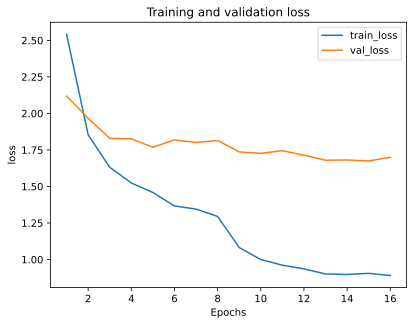

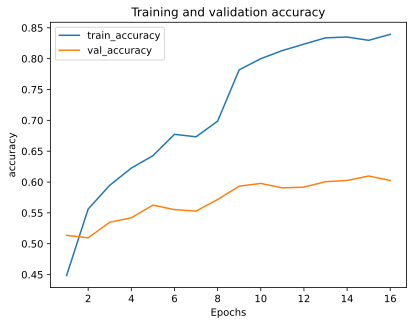

In [14]:
plot_metric(train_resnet,"loss")
plot_metric(train_resnet,"accuracy")

